In [16]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor
import copy

#### Load fit results

In [11]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

# fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
fitting_type1 = 'gabor_solo_ridge_12ori_8sf_from_residuals'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) for ss in subjects]

n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# load the semantic voxel groups
# these are already thresholded based on permutation test, so no need to do any other thresholding
from analyze_fits import sem_voxel_groups
sem_groups, sem_group_names = sem_voxel_groups.get_sem_voxel_groups(n_vox_in_group = 500)
n_sem_groups = len(sem_group_names)

#### Get info about the Gabor feature space

In [12]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [13]:
feature_corr1 = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes across orient/SF.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
assert(not(np.any(is_constant1)))

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
assert(not(np.any(is_constant1)))



In [14]:
n_vox = preferred_ori_corr1.shape[0]
feature_prefs_2dhist_resid = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr1[vv])
    ff = int(preferred_sf_corr1[vv])
    feature_prefs_2dhist_resid[vv,oo,ff] = 1
   

In [15]:
avg_resp_profiles_resid = np.zeros((n_subjects, n_sem_groups, n_ori, n_sf))

for ri in range(n_sem_groups): 
    
    sem_group_inds = np.concatenate(sem_groups, axis=0)[:,ri]
    
    print(np.sum(sem_group_inds), sem_group_names[ri])
    
    for si in range(n_subjects):
        
        inds_use = sem_group_inds & (subject_inds==si)
        
        avg_resp_profiles_resid[si,ri,:,:] = np.mean(allcorr_reshaped1[inds_use,:,:], axis=0)

4000 face
4000 building
4000 animate
4000 inanimate
4000 small
4000 large
4000 indoor
4000 outdoor


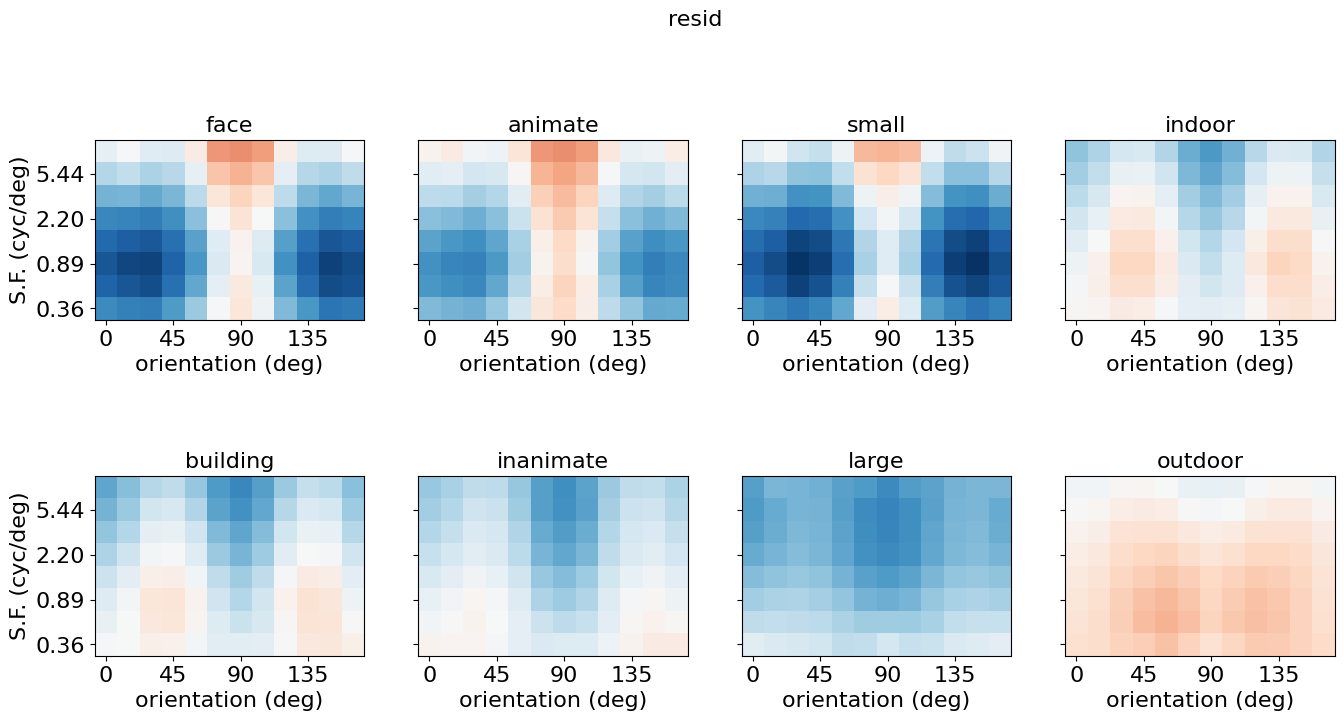

In [7]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

# plot_inds = np.array([0,4,8,1,5,9,2,6,10,3,7,11])+1
plot_inds = np.array([0,4,1,5,2,6,3,7])+1

for rname, respvals in zip(['resid'], [avg_resp_profiles_resid]):

    plt.figure(figsize=(16,8))
    
    pi=0

    clims = [-0.6, 0.6]

    pairs = [[0,1],[2,3],[4,5],[6,7]]

    for pair_ind, pair in enumerate(pairs):

        for xx in [0,1]:

            pi+=1
            plt.subplot(2,4,plot_inds[pi-1])

            # print(pair[xx])
            
#             if xx<2:
            vals = np.mean(respvals[:,pair[xx],:,:], axis=0)
            name = sem_group_names[pair[xx]]
#             else:
            # vals = np.mean(respvals[:,pair[0],:,:] - respvals[:,pair[1],:,:], axis=0)
            # name = '%s - %s'%(sem_group_names[pair[0]], sem_group_names[pair[1]])

            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if pair_ind==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('S.F. (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])
            # plt.axis('off')
            # plt.colorbar()

            plt.xlabel('orientation (deg)')
            # else:
            #     plt.yticks(np.array([0,2,4,6])+0.5, [])

            plt.title(name)

    plt.suptitle(rname)
# plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out_resid))

fn2save = os.path.join(default_paths.fig_path, 'Feature_selectivity_sem_voxel_groups.pdf')
plt.savefig(fn2save)

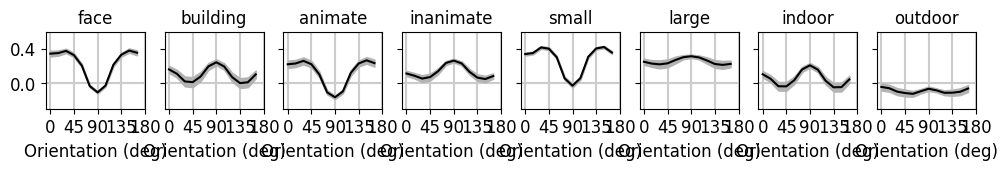

In [8]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,1))

npy = 8;
npx = 1;

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

pi=0

for rr in range(n_sem_groups):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    
    vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=2)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(ori_unique,  meanvals, '-',color='k')
    plt.fill_between(ori_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8],zorder=-10)
    plt.ylim(ylims)
    
    if np.mod(pi,npy)==1:
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    if ri>=0:
        plt.xlabel('Orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8],zorder=-10)

    plt.title('%s'%(sem_group_names[rr]))
    
fn2save = os.path.join(default_paths.fig_path, 'Marginal_orient_profiles_semantic_groups.pdf')
plt.savefig(fn2save)

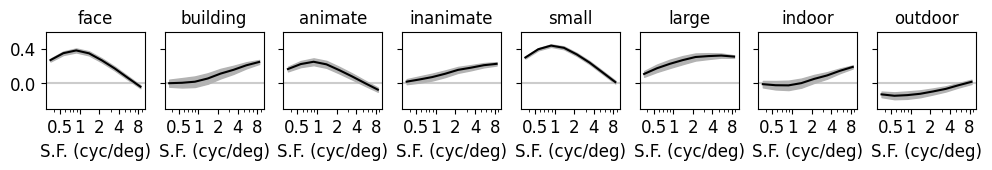

In [9]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,1))

npy = 8;
npx = 1;

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

pi=0

for rr in range(n_sem_groups):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles_resid[:,rr,:,:], axis=1)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(sf_unique,  meanvals, '-',color='k')
    plt.fill_between(sf_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8], zorder=-10)
    plt.ylim(ylims)
    
    if np.mod(pi,npy)==1:
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    plt.gca().set_xscale('log')
    if ri>=0:
        plt.xlabel('S.F. (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(sem_group_names[rr]))

fn2save = os.path.join(default_paths.fig_path, 'Marginal_freq_profiles_semantic_groups.pdf')
plt.savefig(fn2save)